# Data Analysis Project: [E-Commerce Public Dataset]
- **Name:** [Rudianto]
- **Email:** [rudrud1899@gmail.com]
- **ID Coding:** [rudrud]

## Defining Business Questions

- How's the order_ratio on our payment type that customer used to pay?
- Which products do customers purchase using a credit card with the highest number of installments? List the top 5 products.

## Import All Packages/Libraries Used

In [114]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

## Data Wrangling

### Gathering Data

In [115]:
conn = duckdb.connect()
conn.sql('INSTALL spatial')
conn.sql('LOAD spatial')

product_df = conn.execute('''SELECT item_dataset.*,  product_category_name FROM './datasets/olist_order_items_dataset.csv' as item_dataset
                          LEFT JOIN './datasets/olist_products_dataset.csv' as product_dataset
                          ON product_dataset.product_id = item_dataset.product_id
           ''').fetchdf()

### Assessing Data

In [116]:
print(product_df.isnull().sum())
print(product_df.duplicated().sum())

order_id                    0
order_item_id               0
product_id                  0
seller_id                   0
shipping_limit_date         0
price                       0
freight_value               0
product_category_name    1603
dtype: int64
0


## Exploratory Data Analysis (EDA)

In [117]:
payment_type_result = conn.execute('''
                         SELECT payment_type, 
                         count(order_id) as total_order, 
                         sum(cast (payment_value as decimal)) as total_payment,
                         round((count(order_id) / sum(count(order_id)) over ()) * 100,0)  as order_ratio,
                         round((sum(payment_value) / sum(sum(payment_value)) over ()) * 100,0) as payment_value_ratio
                         FROM './datasets/olist_order_payments_dataset.csv'
                         
                         GROUP BY payment_type
                         ORDER BY count(order_id) DESC
                      ''').fetchdf()

payment_type_result

,payment_type,total_order,total_payment,order_ratio,payment_value_ratio
0,credit_card,76795,12542084.19,74.0,78.0
1,boleto,19784,2869361.27,19.0,18.0
2,voucher,5775,379436.87,6.0,2.0
3,debit_card,1529,217989.79,1.0,1.0
4,not_defined,3,0.00,0.0,0.0


In [118]:
payment_result = conn.execute('''
             -- finding most using payment_installments
             With most_payment_installments as ( 
             SELECT payment_installments, sum(payment_value) as total_payment
             FROM './datasets/olist_order_payments_dataset.csv'
             WHERE  payment_type  like '%credit_card%'
             group by payment_installments
             order by total_payment desc limit 1),
             
             -- getting product based in  most_payment_installments to find product_category_name
             order_output as (
               SELECT * FROM './datasets/olist_order_payments_dataset.csv' as payment_installments_dataset
               WHERE  payment_type  like '%credit_card%' and payment_installments = (select payment_installments from most_payment_installments) 
             ),
             
             -- getting product name based on order_id
             product_category_output as (
               select payment_installments, product_df.product_category_name, count(order_output.order_id) as total_order, sum(payment_value) as total_payment from order_output
               INNER JOIN product_df ON order_output.order_id = product_df.order_id
               group by payment_installments , product_df.product_category_name
               order by total_payment desc limit 5
             )
             
             select * from product_category_output
             order by total_order desc
             ''').fetchdf()

payment_result

,payment_installments,product_category_name,total_order,total_payment
0,1,esporte_lazer,2674,282508.96
1,1,informatica_acessorios,2381,295715.74
2,1,beleza_saude,2027,212605.20
3,1,moveis_decoracao,1876,221751.53
4,1,cama_mesa_banho,1826,204268.56


## Visualization & Explanatory Analysis

### Question 1:

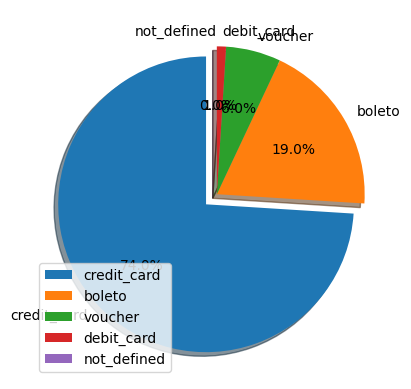

In [119]:
plt.pie(
  x= payment_type_result['order_ratio'],
  labels=payment_type_result['payment_type'],
  explode=(0.1, 0, 0, 0, 0),
  shadow=True,
  startangle=90,
  autopct='%1.1f%%',
)

plt.legend(payment_type_result['payment_type'], loc='lower left')
plt.show()

### Pertanyaan 2:

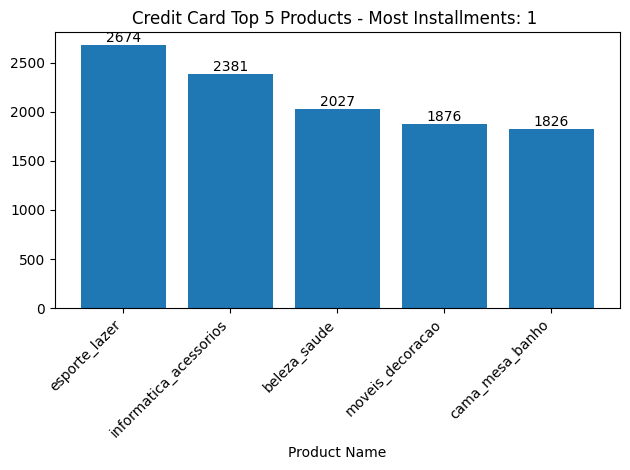

In [120]:
plt.bar(x=payment_result['product_category_name'],height=payment_result['total_order'])
plt.xlabel("Product Name")
plt.title(f"Credit Card Top 5 Products - Most Installments: {payment_result['payment_installments'][0]} ")

# Add labels on top of the bars
for i, value in enumerate(payment_result['total_order']):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')  # Adjust the label position slightly above the bar

plt.xticks(rotation=45, ha='right')  # Rotates labels 45 degrees and aligns them to the right
plt.tight_layout()  # This automatically adjusts the padding to fit the labels
plt.show()

## Analisis Lanjutan (Opsional)

## Conclusion

- Conclution pertanyaan 1
- Conclution pertanyaan 2